# P07 - Implémentez un modèle de scoring


Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

Logo entreprise 
 

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

Les données
Voici les données dont vous aurez besoin pour réaliser le dashboard. Pour plus de simplicité, vous pouvez les télécharger à cette adresse.

Vous aurez sûrement besoin de joindre les différentes tables entre elles.

Votre mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
Michaël, votre manager, vous incite à sélectionner un kernel Kaggle pour vous faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. Vous analyserez ce kernel et l’adapterez pour vous assurer qu’il répond aux besoins de votre mission.

Vous pourrez ainsi vous focaliser sur l’élaboration du modèle, son optimisation et sa compréhension.

Spécifications du dashboard
Michaël vous a fourni des spécifications pour le dashboard interactif. Celui-ci devra contenir au minimum les fonctionnalités suivantes :

Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

- supprimer variables si valeurs manquantes trop élevées (+10%)
- matrice de confusion
- threshold
- hyperopt f2 f3

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import re

# modèles et métriques
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score, fbeta_score, roc_auc_score, precision_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# sur- et sous-échantillonage
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

# optimisation du modèle
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score

# import des données
import joblib

# interprétation des résultats
from lime.lime_tabular import LimeTabularExplainer
import shap
from sklearn.neighbors import NearestNeighbors



warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set()
plt.style.use('seaborn-whitegrid')

## Observation des données disponibles

- 2 csv que nous n'utiliserons pas (le csv de test qui n'a pas de labels et une liste de labels à 0.5).
- 7 csv avec les données à utiliser.
- 1 csv avec la définition des colonnes.

- Dataset déséquilibré entre la target 1 (8%) et la target 0 (92%).

In [5]:
path = 'home-credit-default-risk/'

# données
application = pd.read_csv(path + 'application_train.csv')
bureau = pd.read_csv(path + 'bureau.csv')
b_balance = pd.read_csv(path + 'bureau_balance.csv')
cc_balance = pd.read_csv(path + 'credit_card_balance.csv')
payments = pd.read_csv(path + 'installments_payments.csv')
pos = pd.read_csv(path + 'POS_CASH_balance.csv')
prev_application = pd.read_csv(path + 'previous_application.csv')

# description des colonnes -- nécessite pandas 1.2.4
col_desc = pd.read_csv(path + 'HomeCredit_columns_description.csv')

In [6]:
col_desc[col_desc['Row'] == 'AMT_ANNUITY']

Unnamed: 0                         Table          Row  \
9           12  application_{train|test}.csv  AMT_ANNUITY   
138        141                    bureau.csv  AMT_ANNUITY   
176        179      previous_application.csv  AMT_ANNUITY   

                             Description Special  
9                           Loan annuity     NaN  
138  Annuity of the Credit Bureau credit     NaN  
176      Annuity of previous application     NaN

In [7]:
datasets = [application, bureau, b_balance, cc_balance, payments,
            pos, prev_application, col_desc]
datasets_names = ["application", "bureau", "b_balance", "cc_balance",
                  "payments", "pos", "prev_application", "col_desc"]

for d, n in zip(datasets, datasets_names):
    print(n, ':\n', d.columns, '\nshape:', d.shape, '\n')
    print(d.nunique(), '\n\nValeurs nulles :\n', d.isna().sum(), '\n')

application :
 Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122) 
shape: (307511, 122) 

SK_ID_CURR                    307511
TARGET                             2
NAME_CONTRACT_TYPE                 2
CODE_GENDER                        3
FLAG_OWN_CAR                       2
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY          9
AMT_REQ_CREDIT_BUREAU_WEEK         9
AMT_REQ_CREDIT_BUREAU_MON         24
AMT_REQ_CREDIT_BUREAU_QRT         11
AMT_REQ_CREDIT_BUREAU_YEAR        25
Length: 122, dtype: int64 

Valeur

SK_ID_PREV                     1670214
SK_ID_CURR                      338857
NAME_CONTRACT_TYPE                   4
AMT_ANNUITY                     357959
AMT_APPLICATION                  93885
AMT_CREDIT                       86803
AMT_DOWN_PAYMENT                 29278
AMT_GOODS_PRICE                  93885
WEEKDAY_APPR_PROCESS_START           7
HOUR_APPR_PROCESS_START             24
FLAG_LAST_APPL_PER_CONTRACT          2
NFLAG_LAST_APPL_IN_DAY               2
RATE_DOWN_PAYMENT               207033
RATE_INTEREST_PRIMARY              148
RATE_INTEREST_PRIVILEGED            25
NAME_CASH_LOAN_PURPOSE              25
NAME_CONTRACT_STATUS                 4
DAYS_DECISION                     2922
NAME_PAYMENT_TYPE                    4
CODE_REJECT_REASON                   9
NAME_TYPE_SUITE                      7
NAME_CLIENT_TYPE                     4
NAME_GOODS_CATEGORY                 28
NAME_PORTFOLIO                       5
NAME_PRODUCT_TYPE                    3
CHANNEL_TYPE             

In [8]:
# Diagramme en secteurs
(application["TARGET"].value_counts(normalize=True)
 .plot(kind='pie', shadow=True,
       colors=['lightcyan', 'paleturquoise'],
       autopct='%1.0f%%'))

plt.axis('equal')
plt.title('Proportion des targets', size=18);

## Preprocessing des données

- On se base sur le kernel suivant pour le feature engineering : https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features
- On utilise seulement le dataset de base application_train.csv qui donne les informations principales. Après avoir testé avec l'ensemble des datasets on obtient un modèle légèrement meilleur (+0.01 roc_auc score) mais qui demanderait plus de ressources pour le déploiement.

In [9]:
# One-hot encoding pour les variables catégorielles
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [10]:
# Preprocessing de application_train.csv
def application_train(data):
    df = data.copy()
    # On retire les 4 entrées avec XNA pour en faire une catégorie binaire
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Encoding des catégories binaires
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Encoding des autres catégories
    df, cat_cols = one_hot_encoder(df, nan_as_category=False)
    
    # On remplace les valeurs aberrantes (365243) par NaN
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # On créé de nouvelles features (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    return df

In [11]:
df = application_train(application)

In [12]:
# On retire les caractères spéciaux des noms des colonnes, sinon LGBM ne fonctionne pas
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df.shape

(307507, 247)

- Après preprocessing du dataset application on obtient 245 variables + l'ID et la target.

In [13]:
df.head(2)

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002       1            0             0                0   
1      100003       0            1             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   

   ...  WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stonebrick  \
0  ...                         0                              1   
1  ...                         0                              0   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  \
0                          0                       1                        0   
1                          0                       1                        0   

   DAYS_EMPLOYED_PERC  INCOME_CREDIT_PERC  INCOME_PER_PERSON  \
0            0.067329            0.498036           202500.0   
1            0.070862            0.208736           135000.0   

   ANNUITY_INCOME_PERC  PAYMENT_RATE  
0             0.121978      0.060749  
1             0.132217      0.027598  

[2 rows x 247 columns]

- Séparation entre train et test set en conservant la proportion des targets :

In [14]:
X = df[[f for f in df.columns if f not in ['TARGET','SK_ID_CURR']]]
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    stratify=y, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (246005, 245)
X_test shape: (61502, 245)


- Imputation des valeurs manquantes et normalisation des données :

In [15]:
columns = X_train.columns
train_index = X_train.index
test_index = X_test.index

imputer = SimpleImputer(strategy = 'mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), index=train_index, columns=columns)
X_test = pd.DataFrame(imputer.transform(X_test), index=test_index, columns=columns)

# échantillon du test set pour l'API
sample = X_test.sample(1000, random_state=4)
sample.to_csv('sample.csv')

cat_cols = [col for col in X_train if np.isin(X_train[col].unique(), [0, 1]).all()]
num_cols = [col for col in X_train if not np.isin(X_train[col].unique(), [0, 1]).all()]

scaler = StandardScaler().fit(X_train[num_cols].values)
X_train[num_cols] = scaler.transform(X_train[num_cols].values)
X_test[num_cols] = scaler.transform(X_test[num_cols].values)

- Import du scaler pour l'API :

In [16]:
joblib.dump(scaler, "scaler.jbl")

['scaler.jbl']

## Test des différents modèles

### Sans modifier l'échantillonage, avec et sans sample_weights

In [58]:
results = pd.DataFrame(index=['accuracy', 'precision', 'recall',
                              'f1', 'f2', 'roc_auc', 'time'])

def get_scores(y_test, pred, proba, t0=0, t1=0):
    return [accuracy_score(y_test, pred),
            precision_score(y_test, pred),
            recall_score(y_test, pred),
            f1_score(y_test, pred),
            fbeta_score(y_test, pred, beta=2),
            roc_auc_score(y_test, proba),
            t1 - t0]


def compare_models(X_train, X_test, y_train, y_test, df, suffix, class_weights=None):

    weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
    if class_weights == None:
        weights = None
        
    t0 = time.time()
    xgb = XGBClassifier(use_label_encoder=False, random_state=42)
    xgb.fit(X_train, y_train, sample_weight=weights)
    pred_xgb = xgb.predict(X_test)
    proba_xgb = xgb.predict_proba(X_test)[:, 1]
    t1 = time.time()

    lgbm = LGBMClassifier(class_weight=class_weights, random_state=42)
    lgbm.fit(X_train, y_train)
    pred_lgbm = lgbm.predict(X_test)
    proba_lgbm = lgbm.predict_proba(X_test)[:, 1]
    t2 = time.time()

    rf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    proba_rf = rf.predict_proba(X_test)[:, 1]
    t3 = time.time()

    lr = LogisticRegression(class_weight=class_weights, max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)
    pred_lr = lr.predict(X_test)
    proba_lr = lr.predict_proba(X_test)[:, 1]
    t4 = time.time()
    
    df['XGB_' + suffix] = get_scores(y_test, pred_xgb, proba_xgb, t0, t1)
    df['LGBM_' + suffix] = get_scores(y_test, pred_lgbm, proba_lgbm, t1, t2)
    df['RF_' + suffix] = get_scores(y_test, pred_rf, proba_rf, t2, t3)
    df['LR_' + suffix] = get_scores(y_test, pred_lr, proba_lr, t3, t4)
    return round(df, 3)

In [59]:
results = compare_models(X_train, X_test, y_train, y_test, results, 'no_weight')
results = compare_models(X_train, X_test, y_train, y_test, results, 'class_weigth', 'balanced')
results

[17:55:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:59:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGB_no_weight  LGBM_no_weight  RF_no_weight  LR_no_weight  \
accuracy           0.919           0.920         0.919         0.920   
precision          0.514           0.584         1.000         0.560   
recall             0.037           0.020         0.001         0.015   
f1                 0.069           0.038         0.001         0.029   
f2                 0.046           0.024         0.001         0.019   
roc_auc            0.765           0.767         0.711         0.751   
time              55.721           5.764       132.150        45.403   

           XGB_class_weigth  LGBM_class_weigth  RF_class_weigth  \
accuracy              0.740              0.711            0.919   
precision             0.181              0.174            0.500   
recall                0.630              0.686            0.002   
f1                    0.281              0.277            0.004   
f2                    0.421              0.432            0.002   
roc_auc               0.758              0.769            0.725   
time                 54.839              4.982          115.637   

           LR_class_weigth  
accuracy             0.692  
precision            0.163  
recall               0.679  
f1                   0.262  
f2                   0.415  
roc_auc              0.751  
time                53.426

### Test avec undersampling

In [60]:
sample = RandomUnderSampler(random_state=10)
X_under, y_under = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_under))

Counter({0: 226145, 1: 19860})
Counter({0: 19860, 1: 19860})


In [61]:
results = compare_models(X_under, X_test, y_under, y_test, results, 'rdm_under')
results

[18:03:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGB_no_weight  LGBM_no_weight  RF_no_weight  LR_no_weight  \
accuracy           0.919           0.920         0.919         0.920   
precision          0.514           0.584         1.000         0.560   
recall             0.037           0.020         0.001         0.015   
f1                 0.069           0.038         0.001         0.029   
f2                 0.046           0.024         0.001         0.019   
roc_auc            0.765           0.767         0.711         0.751   
time              55.721           5.764       132.150        45.403   

           XGB_class_weigth  LGBM_class_weigth  RF_class_weigth  \
accuracy              0.740              0.711            0.919   
precision             0.181              0.174            0.500   
recall                0.630              0.686            0.002   
f1                    0.281              0.277            0.004   
f2                    0.421              0.432            0.002   
roc_auc               0.758              0.769            0.725   
time                 54.839              4.982          115.637   

           LR_class_weigth  XGB_rdm_under  LGBM_rdm_under  RF_rdm_under  \
accuracy             0.692          0.688           0.695         0.696   
precision            0.163          0.161           0.166         0.160   
recall               0.679          0.683           0.691         0.649   
f1                   0.262          0.261           0.268         0.256   
f2                   0.415          0.415           0.423         0.402   
roc_auc              0.751          0.752           0.763         0.735   
time                53.426         10.793           1.769        19.471   

           LR_rdm_under  
accuracy          0.691  
precision         0.162  
recall            0.677  
f1                0.261  
f2                0.414  
roc_auc           0.750  
time              5.041

### Test avec oversampling (SMOTE 50%)

In [62]:
sample = SMOTE(sampling_strategy=0.5, random_state=42)
X_over, y_over = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_over))

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 113072})


In [63]:
results = compare_models(X_over, X_test, y_over, y_test, results, 'SMOTE')
results

[18:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGB_no_weight  LGBM_no_weight  RF_no_weight  LR_no_weight  \
accuracy           0.919           0.920         0.919         0.920   
precision          0.514           0.584         1.000         0.560   
recall             0.037           0.020         0.001         0.015   
f1                 0.069           0.038         0.001         0.029   
f2                 0.046           0.024         0.001         0.019   
roc_auc            0.765           0.767         0.711         0.751   
time              55.721           5.764       132.150        45.403   

           XGB_class_weigth  LGBM_class_weigth  RF_class_weigth  \
accuracy              0.740              0.711            0.919   
precision             0.181              0.174            0.500   
recall                0.630              0.686            0.002   
f1                    0.281              0.277            0.004   
f2                    0.421              0.432            0.002   
roc_auc               0.758              0.769            0.725   
time                 54.839              4.982          115.637   

           LR_class_weigth  XGB_rdm_under  LGBM_rdm_under  RF_rdm_under  \
accuracy             0.692          0.688           0.695         0.696   
precision            0.163          0.161           0.166         0.160   
recall               0.679          0.683           0.691         0.649   
f1                   0.262          0.261           0.268         0.256   
f2                   0.415          0.415           0.423         0.402   
roc_auc              0.751          0.752           0.763         0.735   
time                53.426         10.793           1.769        19.471   

           LR_rdm_under  XGB_SMOTE  LGBM_SMOTE  RF_SMOTE  LR_SMOTE  
accuracy          0.691      0.919       0.920     0.919     0.837  
precision         0.162      0.514       0.607     0.800     0.226  
recall            0.677      0.039       0.021     0.001     0.420  
f1                0.261      0.073       0.040     0.002     0.294  
f2                0.414      0.048       0.025     0.001     0.358  
roc_auc           0.750      0.761       0.762     0.711     0.746  
time              5.041    116.293      11.681   178.740    71.407

### Test avec oversampling  puis undersampling

In [64]:
sample = SMOTE(sampling_strategy=0.2, random_state=42)
X_over, y_over = sample.fit_resample(X_train, y_train)

print(Counter(y_train))
print(Counter(y_over))

sample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_under, y_under = sample.fit_resample(X_over, y_over)

print(Counter(y_train))
print(Counter(y_under))

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 45229})
Counter({0: 226145, 1: 19860})
Counter({0: 90458, 1: 45229})


In [65]:
results = compare_models(X_under, X_test, y_under, y_test, results, 'SMOTE+under')
results

[18:10:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGB_no_weight  LGBM_no_weight  RF_no_weight  LR_no_weight  \
accuracy           0.919           0.920         0.919         0.920   
precision          0.514           0.584         1.000         0.560   
recall             0.037           0.020         0.001         0.015   
f1                 0.069           0.038         0.001         0.029   
f2                 0.046           0.024         0.001         0.019   
roc_auc            0.765           0.767         0.711         0.751   
time              55.721           5.764       132.150        45.403   

           XGB_class_weigth  LGBM_class_weigth  RF_class_weigth  \
accuracy              0.740              0.711            0.919   
precision             0.181              0.174            0.500   
recall                0.630              0.686            0.002   
f1                    0.281              0.277            0.004   
f2                    0.421              0.432            0.002   
roc_auc               0.758              0.769            0.725   
time                 54.839              4.982          115.637   

           LR_class_weigth  XGB_rdm_under  LGBM_rdm_under  RF_rdm_under  \
accuracy             0.692          0.688           0.695         0.696   
precision            0.163          0.161           0.166         0.160   
recall               0.679          0.683           0.691         0.649   
f1                   0.262          0.261           0.268         0.256   
f2                   0.415          0.415           0.423         0.402   
roc_auc              0.751          0.752           0.763         0.735   
time                53.426         10.793           1.769        19.471   

           LR_rdm_under  XGB_SMOTE  LGBM_SMOTE  RF_SMOTE  LR_SMOTE  \
accuracy          0.691      0.919       0.920     0.919     0.837   
precision         0.162      0.514       0.607     0.800     0.226   
recall            0.677      0.039       0.021     0.001     0.420   
f1                0.261      0.073       0.040     0.002     0.294   
f2                0.414      0.048       0.025     0.001     0.358   
roc_auc           0.750      0.761       0.762     0.711     0.746   
time              5.041    116.293      11.681   178.740    71.407   

           XGB_SMOTE+under  LGBM_SMOTE+under  RF_SMOTE+under  LR_SMOTE+under  
accuracy             0.904             0.909           0.915           0.840  
precision            0.333             0.367           0.354           0.230  
recall               0.188             0.170           0.067           0.420  
f1                   0.240             0.232           0.113           0.297  
f2                   0.206             0.190           0.080           0.360  
roc_auc              0.762             0.765           0.725           0.748  
time                38.795             5.892          65.762          23.505

## Analyse des modèles

- Suite aux différents tests on choisit de conserver le modèle LGBM avec class_weights.

### Classement des modèles

In [79]:
best_models = results.T.sort_values(by='roc_auc', ascending=False).head(5)
best_models

accuracy  precision  recall     f1     f2  roc_auc    time
LGBM_class_weigth     0.711      0.174   0.686  0.277  0.432    0.769   4.982
LGBM_no_weight        0.920      0.584   0.020  0.038  0.024    0.767   5.764
XGB_no_weight         0.919      0.514   0.037  0.069  0.046    0.765  55.721
LGBM_SMOTE+under      0.909      0.367   0.170  0.232  0.190    0.765   5.892
LGBM_rdm_under        0.695      0.166   0.691  0.268  0.423    0.763   1.769

In [81]:
results = best_models.head(1).T

### Courbe Roc

In [70]:
model = LGBMClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
score = model.predict_proba(X_test)[:, 1]

In [71]:
def plot_roc_curve(X_test, y_test, score):
    fpr, tpr, thresholds = roc_curve(y_test, score)
    plt.plot(fpr, tpr, marker='.', label='LGBM')

    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')

    plt.legend()
    plt.show()

    print('roc_auc_score: %.3f' % roc_auc_score(y_test, score))


plot_roc_curve(X_test, y_test, score)

roc_auc_score: 0.769


### Courbe précision-rappel

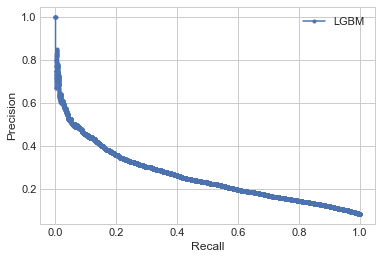

AUC PR: 0.260


In [72]:
def plot_precision_recall_curve(X_test, y_test, score):
    precision, recall, thresholds = precision_recall_curve(y_test, score)

    plt.plot(recall, precision, marker='.', label='LGBM')

    plt.xlabel('Recall')
    plt.ylabel('Precision')

    plt.legend()
    plt.show()

    print('AUC PR: %.3f' % auc(recall, precision))
    

plot_precision_recall_curve(X_test, y_test, score)

## Optimisation du modèle

### Hyperopt

In [15]:
space={'n_estimators': scope.int(hp.quniform('n_estimators', 200, 2000, 200)),
       'max_depth' : scope.int(hp.quniform('max_depth', 2, 30, 2)),
       'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
       'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
       'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
       'num_leaves': scope.int(hp.quniform('num_leaves', 4, 100, 4)),
       'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
       'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1)
}

In [30]:
def hyperparameter_tuning(params):
    clf = LGBMClassifier(**params, class_weight='balanced', n_jobs=-1, random_state=42)
    score = cross_val_score(clf, X_train, y_train ,scoring="f1_weighted", error_score='raise').mean()
    return {"loss": -score, "status": STATUS_OK}

In [32]:
trials = Trials()

best = fmin(fn=hyperparameter_tuning,
            space = space, 
            algo=tpe.suggest, 
            max_evals=10, 
            trials=trials
            )

print("Best: {}".format(best))

100%|██████████| 10/10 [1:10:15<00:00, 421.52s/trial, best loss: -0.878654326737875]
Best: {'colsample_by_tree': 0.9, 'learning_rate': 0.1809959162061399, 'max_depth': 6.0, 'n_estimators': 1800.0, 'num_leaves': 84.0, 'reg_alpha': 1.0, 'reg_lambda': 0.1, 'subsample': 0.6000000000000001}


In [18]:
# best params roc_auc
model = LGBMClassifier(n_estimators= 1200,
       max_depth= 8,
       learning_rate=0.02,
       subsample=0.2,
       colsample_bytree=0.7,
       num_leaves=20,
       reg_alpha=0.4,
       reg_lambda=0.2,
       class_weight='balanced')

# # best params f1
# model = LGBMClassifier(n_estimators= 1400,
#        max_depth= 18,
#        learning_rate=0.02,
#        subsample=0.4,
#        colsample_bytree=0.9,
#        num_leaves=64,
#        reg_alpha=1.0,
#        reg_lambda=0.4,
#        class_weight='balanced')

# # best params f1_weighted
# model = LGBMClassifier(n_estimators= 1800,
#        max_depth=6,
#        learning_rate=0.18,
#        subsample=0.6,
#        colsample_bytree=0.9,
#        num_leaves=8,
#        reg_alpha=1.0,
#        reg_lambda=0.1,
#        class_weight='balanced')

In [20]:
t0 = time.time()
model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]
t1 = time.time()
results['hyperopt_roc'] = get_scores(y_test, pred, proba, t0, t1)
round(results,3)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7,
               learning_rate=0.02, max_depth=8, n_estimators=1200,
               num_leaves=20, reg_alpha=0.4, reg_lambda=0.2, subsample=0.2)

- import du modèle pour l'API :

In [21]:
joblib.dump(model, "model.jbl")

['model.jbl']

## Interprétation des résultats

### Features importance

In [91]:
feature_importance_values = model.feature_importances_

feats = pd.DataFrame({'feature': list(X_train.columns),
                      'importance': feature_importance_values})

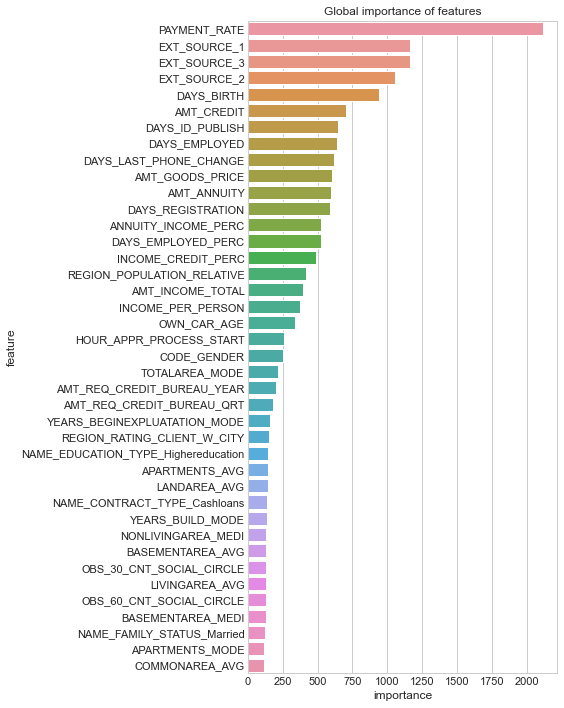

In [97]:
def display_importances(feats, nb_feats):
    cols = feats.groupby("feature").mean().sort_values(by="importance", ascending=False)[:nb_feats].index
    best_feats = feats.loc[feats.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_feats.sort_values(by="importance", ascending=False))
    plt.title('Global importance of features')
    plt.tight_layout()

    
display_importances(feats, 40)

### Lime

In [236]:
# model = joblib.load("model.jbl")
# scaler = joblib.load("scaler.jbl")
# sample = pd.read_csv('sample.csv', index_col=0)
# num_cols = [col for col in sample if not np.isin(sample[col].unique(), [0, 1]).all()]
sample[num_cols] = scaler.transform(sample[num_cols].values)

In [237]:
sample

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
305832          0.0           0.0              1.0     -0.577847   
181847          0.0           0.0              0.0     -0.577847   
91760           1.0           0.0              1.0      2.195035   
68393           1.0           0.0              1.0      2.195035   
196143          0.0           1.0              1.0      0.808594   
...             ...           ...              ...           ...   
170053          1.0           0.0              0.0     -0.577847   
132010          1.0           0.0              0.0     -0.577847   
141849          1.0           0.0              0.0     -0.577847   
300827          1.0           1.0              0.0     -0.577847   
62225           1.0           0.0              0.0     -0.577847   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
305832         -0.441614   -0.451306    -0.651009        -0.482348   
181847         -0.009615   -0.928961    -0.418459        -0.848347   
91760          -0.216975    0.294886    -0.274085         0.164249   
68393          -0.044175   -0.817024     0.231688        -0.726347   
196143          0.474224   -1.294142    -1.280043        -1.275345   
...                  ...         ...          ...              ...   
170053         -0.130575   -1.000757    -0.965836        -1.055746   
132010         -0.044175   -0.089460    -0.216646        -0.226149   
141849         -0.182415    0.254656    -0.456337         0.127649   
300827         -0.216975   -0.114175    -0.491732        -0.165149   
62225           0.042225   -0.200657    -0.123502        -0.299349   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  WALLSMATERIAL_MODE_Panel  \
305832                   -0.193109   -1.369909  ...                       0.0   
181847                    1.077321    0.414175  ...                       1.0   
91760                     0.309413    0.416695  ...                       0.0   
68393                     0.269384    1.096095  ...                       0.0   
196143                   -0.739777    0.786527  ...                       0.0   
...                            ...         ...  ...                       ...   
170053                   -0.750110    0.860998  ...                       0.0   
132010                    0.309413   -1.411612  ...                       0.0   
141849                   -0.746064   -1.558949  ...                       0.0   
300827                    0.269384   -1.721868  ...                       0.0   
62225                    -0.128659   -0.105973  ...                       0.0   

        WALLSMATERIAL_MODE_Stonebrick  WALLSMATERIAL_MODE_Wooden  \
305832                            0.0                        0.0   
181847                            0.0                        0.0   
91760                             0.0                        0.0   
68393                             1.0                        0.0   
196143                            1.0                        0.0   
...                               ...                        ...   
170053                            1.0                        0.0   
132010                            0.0                        0.0   
141849                            0.0                        0.0   
300827                            0.0                        0.0   
62225                             0.0                        0.0   

        EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_Yes  DAYS_EMPLOYED_PERC  \
305832                     0.0                      0.0            0.000000   
181847                     1.0                      0.0           -1.028364   
91760                      0.0                      0.0           -1.060121   
68393                      1.0                      0.0           -0.711228   
196143                     1.0                      0.0           -0.879612   
...                        ...                      ...                 ...   
170053 

In [240]:
# id d'un client non solvable
id_customer_1 = 62225

def plot_lime_explanation(id_customer, df):
    customer = df.loc[id_customer]
    lime = LimeTabularExplainer(df,
                                feature_names=df.columns,
                                class_names=["Solvent", "Not Solvent"],
                                discretize_continuous=False)
    exp = lime.explain_instance(customer,
                                model.predict_proba,
                                num_samples=100)

    exp.show_in_notebook(show_table=True)
    exp.as_pyplot_figure()
#     plt.tight_layout()
    
    
plot_lime_explanation(id_customer_1, sample)

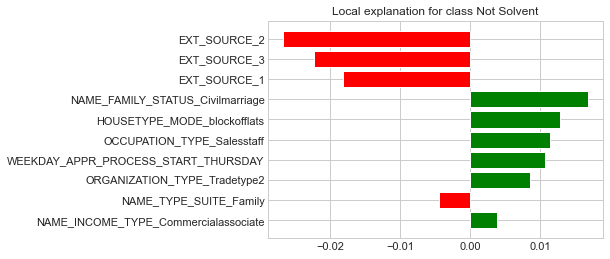

In [242]:
# id d'un client solvable
id_customer_0 = 181847

plot_lime_explanation(id_customer_0, sample)

### Shap

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


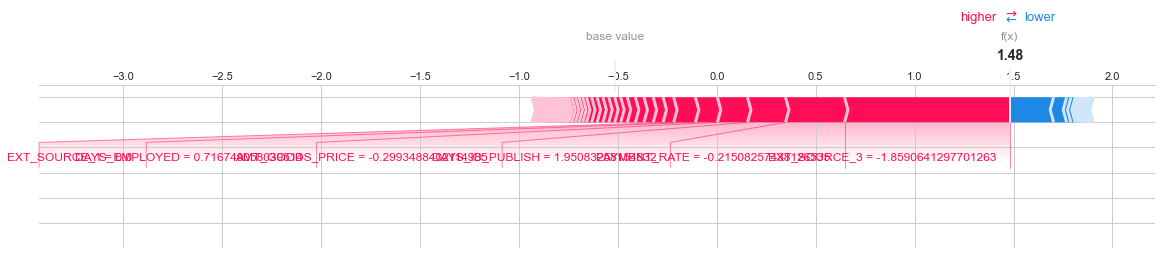

In [243]:
def plot_shap_explanation(model, df, id_customer):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)
    i = df.index.get_loc(id_customer)
    shap.force_plot(matplotlib=True,
                    base_value=explainer.expected_value[1],
                    shap_values=shap_values[1][i],
                    features=df.loc[id_customer],
                    feature_names=df.columns
                    )

    
plot_shap_explanation(model, sample, id_customer_1)

In [244]:
plot_shap_explanation(model, sample, id_customer_0)

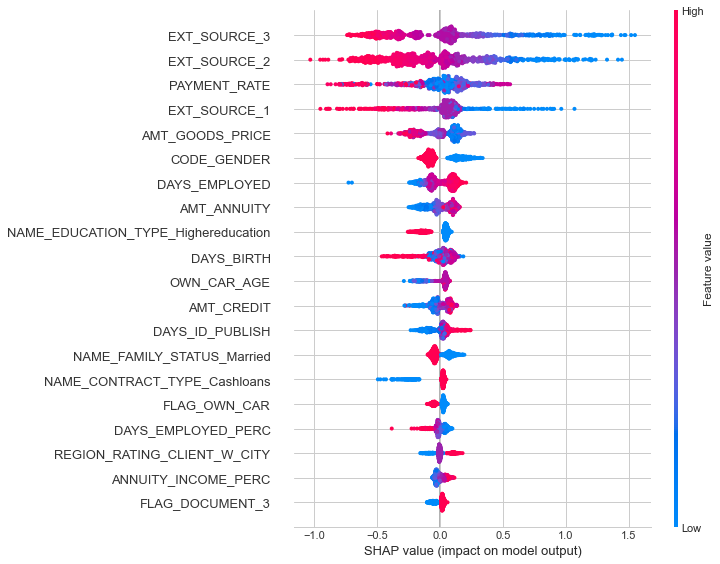

In [246]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values[1], sample)

### Clients similaires

In [283]:
def get_closest_neighbors(df, id_customer, n_neighbors=6):
    nn_model = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = nn_model.fit(df)
    list_neighbors = nn_model.kneighbors([sample.loc[id_customer]])[1].flatten()
    neighbors_ids = []
    for n in list_neighbors:
        neighbors_ids.append(df.iloc[n].name)
    return neighbors_ids[1:]

X does not have valid feature names, but NearestNeighbors was fitted with feature names


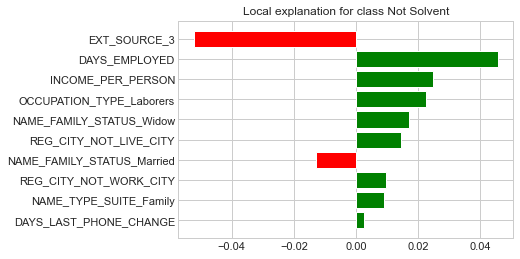

In [287]:
neighbors_1 = get_closest_neighbors(sample, id_customer_1)
plot_lime_explanation(neighbors_1[0], sample)

X does not have valid feature names, but NearestNeighbors was fitted with feature names


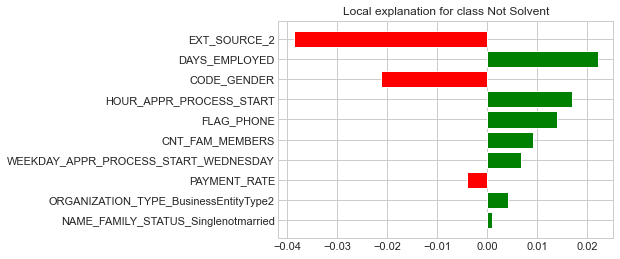

In [288]:
neighbors_0 = get_closest_neighbors(sample, id_customer_0)
plot_lime_explanation(neighbors_0[0], sample)